# Exercise 12 - Learning Strain Distributions

### Task

Tune an advanced neural network to learn strain distributions

* Perform a training with the tensorBoard options (`writeGraph`, `writeHistogram`, `writeLearningHistory`, `writePredictions`) enabled
* Invoke TensorBoard from the terminal with `tensorboard --logdir=logs` (while being in the same directory as this notebook).
If necessary, run `conda activate aicome` first.
Open TensorBoard at: http://localhost:6006
* Compare the performance of the three neural network architectures by changing `selectNN` and using TensorBoard (in the scalars menu, make sure to toggle the y-axis log scale)
* Tune the hyperparameters (turn off the `writeHistogram` and `writePredictions`)
* Increase the number of training samples with `numberOfTrainingSamples` and readjust the hyperparameters if necessary
* Add L2 regularization with `weightDecay`

In [ ]:
!pip install torchinfo

# para instalar o torchinfo (para rodar no colab)

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchinfo import summary
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
# import NeuralNetwork - REMOVED TO RUN IN COLAB
import datetime
import copy
import torchvision

In [ ]:
# Placeholder for NeuralNetwork module - ADJUSTMENTS FOR USAGE IN COLAB
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Define your layers here, e.g.,
        # self.fc1 = nn.Linear(in_features, out_features)

    def forward(self, x):
        # Define the forward pass here, e.g.,
        # x = F.relu(self.fc1(x))
        return x # Placeholder return

    class UNet(nn.Module):
        def __init__(self, channels, channelsOut, numberOfConvolutionsPerBlock, kernelSize):
            super().__init__()
            # Placeholder UNet layers
            self.conv = nn.Conv2d(channels[0], channelsOut, kernelSize, padding=kernelSize//2)

        def forward(self, x):
            # Placeholder UNet forward
            return self.conv(x)

    class FeedforwardCNN(nn.Module):
        def __init__(self, channels, channelsOut, kernelSize):
            super().__init__()
            # Placeholder FeedforwardCNN layers
            self.conv = nn.Conv2d(channels[0], channelsOut, kernelSize, padding=kernelSize//2)

        def forward(self, x):
            # Placeholder FeedforwardCNN forward
            return self.conv(x)

    class UNetWithSubsequentFeedforwardCNN(nn.Module):
        def __init__(self, channelsUNet, numberOfConvolutionsPerBlockUNet, channelsFeedforwardCNN, channelsOut, kernelSize):
            super().__init__()
            # Placeholder UNetWithSubsequentFeedforwardCNN layers
            self.unet = NeuralNetwork.UNet(channelsUNet, channelsFeedforwardCNN[0], numberOfConvolutionsPerBlockUNet, kernelSize)
            self.feedforward = NeuralNetwork.FeedforwardCNN(channelsFeedforwardCNN, channelsOut, kernelSize)

        def forward(self, x):
            # Placeholder UNetWithSubsequentFeedforwardCNN forward
            x = self.unet(x)
            x = self.feedforward(x)
            return x

    @staticmethod
    def costFunction(prediction, target):
        # Placeholder cost function (e.g., Mean Squared Error)
        return F.mse_loss(prediction, target)

## User settings

tensorBoard options

In [ ]:
writeGraph = False
writeHistogram = False
writeLearningHistory = False
writePredictions = False

driver setup

In [ ]:
seed = 2
torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
writer = SummaryWriter(log_dir="./logs/fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

neural network architecture selection

In [ ]:
selectNN = 2  # 0 for UNet, 1 for sequential CNN, 2 for UNet with subsequent feedforward CNN

model parameters

In [ ]:
kernelSize = 3

if selectNN == 0:
    channels = [1, 32, 64]
    channelsOut = 3
    numberOfConvolutionsPerBlock = 1
    model = NeuralNetwork.UNet(channels, channelsOut, numberOfConvolutionsPerBlock, kernelSize)
elif selectNN == 1:
    channels = [1, 32, 64, 32]
    channelsOut = 3
    model = NeuralNetwork.FeedforwardCNN(channels, channelsOut, kernelSize)
elif selectNN == 2:
    channelsUNet = [1, 32, 64]
    numberOfConvolutionsPerBlockUNet = 1
    channelsFeedforwardCNN = [64, 32, 16]
    channelsOut = 3
    model = NeuralNetwork.UNetWithSubsequentFeedforwardCNN(channelsUNet, numberOfConvolutionsPerBlockUNet,
                                                           channelsFeedforwardCNN, channelsOut, kernelSize)
model.to(device)
summary(model, (1, 1, 32, 32))
if writeGraph == True:
    writer.add_graph(model, torch.randn((1, 1, 32, 32), device=device))


hyperparameters

In [ ]:
batchSize = 128
alpha = -0.2
beta = 0.2
weightDecay = 0
lr = 2e-3
epochs = 1000
earlyStopping = True

## Pre-processing

prepare dataset

In [ ]:
# Placeholder for elasticityDataset - ADJUSTMENTS FOR USAGE IN COLAB
from torch.utils.data import Dataset

class elasticityDataset(Dataset):
    def __init__(self, device, numberOfSamples):
        # Placeholder for data initialization
        # You should replace this with your actual data loading and processing
        print(f"Initializing elasticityDataset with {numberOfSamples} samples on {device}")
        self.E = torch.randn(numberOfSamples, 1, 32, 32, device=device) # Placeholder for input data
        self.labels = torch.randn(numberOfSamples, 3, 32, 32, device=device) # Placeholder for labels

    def __len__(self):
        # Return the total number of samples
        return len(self.E)

    def __getitem__(self, idx):
        # Return a single sample and its corresponding label
        return self.E[idx], self.labels[idx]

# Assign the placeholder class to NeuralNetwork for now to resolve the AttributeError
# You should adjust this based on where your actual elasticityDataset is defined
NeuralNetwork.elasticityDataset = elasticityDataset

In [ ]:
numberOfTrainingSamples = 1
numberOfSamples = numberOfTrainingSamples + 32
dataset = NeuralNetwork.elasticityDataset(device, numberOfSamples)

dataset.E = (dataset.E - np.mean([3000, 85000])) / np.std([3000, 85000])
datasetTraining, datasetValidation = torch.utils.data.random_split(dataset, [numberOfTrainingSamples,
                                                                             len(dataset) - numberOfTrainingSamples],
                                                                   generator=torch.Generator().manual_seed(2))

dataloaderTraining = DataLoader(datasetTraining, batch_size=batchSize)
dataloaderValidation = DataLoader(datasetValidation, batch_size=len(dataset))

if writePredictions == True:
    sample = next(iter(dataloaderValidation))
    validationLabelImages = torchvision.utils.make_grid(sample[1][:16], normalize=True, value_range=(-1, 1))
    for i in range(3):
        writer.add_image(f'validation label {i + 1}', validationLabelImages[i], dataformats='HW')


Initializing elasticityDataset with 33 samples on cpu


## Training

optimizer and scheduler instantiation

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weightDecay)
lr_lambda = lambda epoch: (beta * epoch + 1) ** alpha
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

history variables

In [ ]:
trainingCostHistory = np.zeros(epochs)
validationCostHistory = np.zeros(epochs)

training loop

In [ ]:
start = time.perf_counter()
start0 = start
bestCost = 1e10

for epoch in range(epochs):
    if writeHistogram == True:
        for name, param in model.named_parameters():
            writer.add_histogram(name, param, epoch)

    model.train()
    for batch, sample in enumerate(dataloaderTraining):
        optimizer.zero_grad()

        prediction = model(sample[0])
        cost = NeuralNetwork.costFunction(prediction, sample[1])

        trainingCostHistory[epoch] += cost.detach() * len(sample[1])

        cost.backward()
        optimizer.step()

    trainingCostHistory[epoch] /= numberOfTrainingSamples
    scheduler.step()
    if writeHistogram == True:
        for name, param in model.named_parameters():
            writer.add_histogram(f'{name}.grad', param.grad, epoch)

    model.eval()
    sample = next(iter(dataloaderValidation))
    with torch.no_grad():
        prediction = model(sample[0])
        cost = NeuralNetwork.costFunction(prediction, sample[1])

        validationCostHistory[epoch] = cost
        if validationCostHistory[epoch] < bestCost:
            modelParametersBest = copy.deepcopy(model.state_dict())
            bestCost = validationCostHistory[epoch]

        if writePredictions == True:
            validationPredictionImages = torchvision.utils.make_grid(prediction[:16], normalize=True,
                                                                     value_range=(-1, 1))
            for i in range(3):
                writer.add_image(f'validation prediction {i + 1}', validationPredictionImages[i], epoch,
                                 dataformats='HW')

    elapsedTime = time.perf_counter() - start
    if epoch % 10 == 0:
        string = "Epoch: {}/{}\t\tTraining cost: {:.2e}\t\tValidation cost: {:.2e}\nElapsed time for last epoch: {:.2f} s"
        print(string.format(epoch + 1, epochs, trainingCostHistory[epoch], validationCostHistory[epoch], elapsedTime))
    start = time.perf_counter()

    if writeLearningHistory == True:
        writer.add_scalar('training_loss', trainingCostHistory[epoch], epoch)
        writer.add_scalar('validation_loss', validationCostHistory[epoch], epoch)

if earlyStopping == True:
    model.load_state_dict(modelParametersBest)
print("Total elapsed time during training: {:.2f} s".format(time.perf_counter() - start0))
writer.close()

Epoch: 1/1000		Training cost: 1.13e+00		Validation cost: 1.08e+00
Elapsed time for last epoch: 0.08 s
Epoch: 11/1000		Training cost: 1.04e+00		Validation cost: 1.01e+00
Elapsed time for last epoch: 0.05 s
Epoch: 21/1000		Training cost: 1.03e+00		Validation cost: 1.00e+00
Elapsed time for last epoch: 0.05 s
Epoch: 31/1000		Training cost: 1.03e+00		Validation cost: 9.99e-01
Elapsed time for last epoch: 0.05 s
Epoch: 41/1000		Training cost: 1.03e+00		Validation cost: 1.00e+00
Elapsed time for last epoch: 0.05 s
Epoch: 51/1000		Training cost: 1.03e+00		Validation cost: 1.00e+00
Elapsed time for last epoch: 0.04 s
Epoch: 61/1000		Training cost: 1.02e+00		Validation cost: 1.00e+00
Elapsed time for last epoch: 0.19 s
Epoch: 71/1000		Training cost: 1.02e+00		Validation cost: 1.00e+00
Elapsed time for last epoch: 0.67 s
Epoch: 81/1000		Training cost: 1.02e+00		Validation cost: 1.00e+00
Elapsed time for last epoch: 0.29 s
Epoch: 91/1000		Training cost: 1.02e+00		Validation cost: 1.00e+00
Elapsed

## Post-processing

learning history

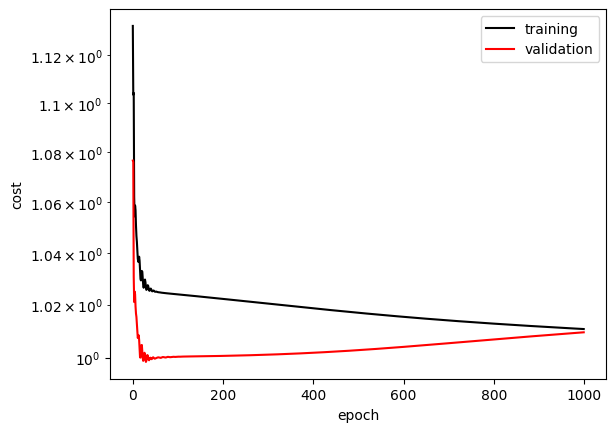

In [ ]:
fig, ax = plt.subplots()
ax.plot(trainingCostHistory, 'k', label='training')
ax.plot(validationCostHistory, 'r', label='validation')
ax.set_yscale('log')
ax.set_ylabel('cost')
ax.set_xlabel('epoch')
ax.legend()
plt.show()

prediction of training sample

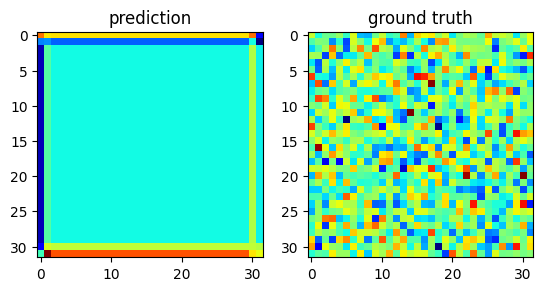

In [ ]:
component = 0
sample = next(iter(dataloaderTraining))

if numberOfTrainingSamples < 4:  # necessary as the batch normalization parameters are not tuned well enough with so few samples
    model.eval()  # ensures that the batch normalization does not continue learning from input data
else:
    model.train()

fig, ax = plt.subplots(1, 2)
ax[0].imshow(model(sample[0])[0, component].detach().cpu(), cmap=plt.cm.jet)
ax[0].set_title('prediction')
ax[1].imshow(sample[1][0, component].detach().cpu(), cmap=plt.cm.jet)
ax[1].set_title('ground truth')
plt.show()

prediction of validation sample

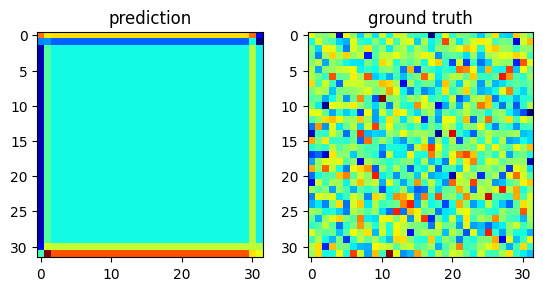

In [ ]:
component = 0
sample = next(iter(dataloaderValidation))

model.eval()  # ensures that the batch normalization does not continue learning from input data
fig, ax = plt.subplots(1, 2)
ax[0].imshow(model(sample[0])[0, component].detach().cpu(), cmap=plt.cm.jet)
ax[0].set_title('prediction')
ax[1].imshow(sample[1][0, component].detach().cpu(), cmap=plt.cm.jet)
ax[1].set_title('ground truth')
plt.show()